In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("creditcard.csv")

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2 - Explorando os Dados

In [4]:
numeros_fraud = len(df[df.Class == 1])
numeros_nao_fraude = len(df[df.Class == 0])

print("Fraude:", numeros_fraud)
print("Normais:", numeros_nao_fraude)

Fraude: 492
Normais: 284315


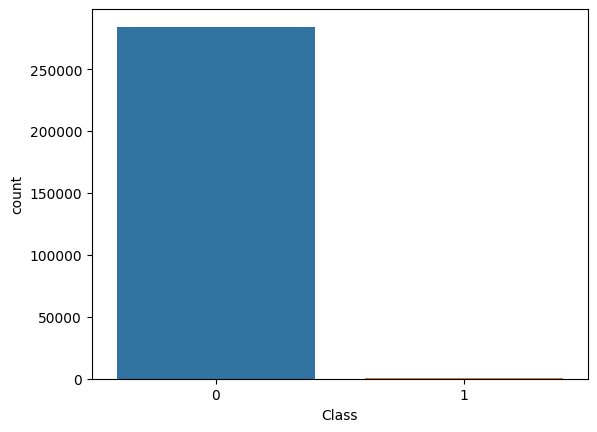

In [5]:
sns.countplot('Class', data=df);

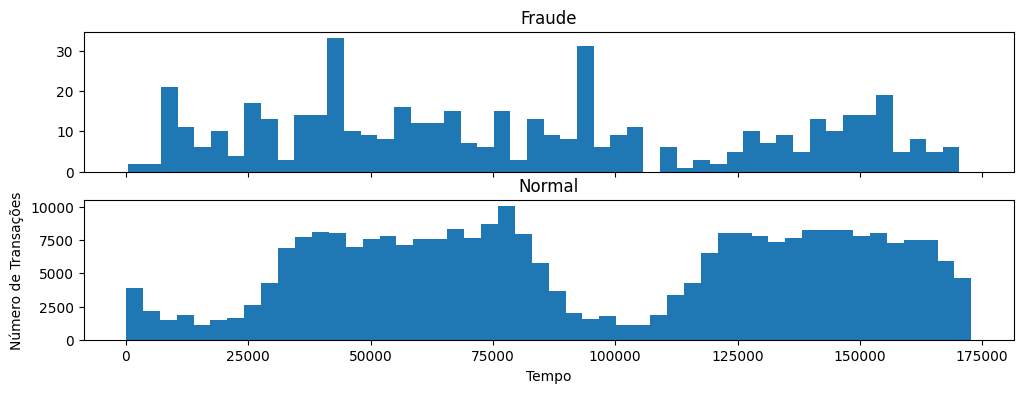

In [6]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
bins = 50

ax1.hist(df.Time[df.Class == 1], bins =bins)
ax1.set_title('Fraude')

ax2.hist(df.Time[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Tempo')
plt.ylabel('Número de Transações')
plt.show()

#### Transações fraudulentas são distribuições de maneira mais uniforme, enquanto as transações Normais são mais cíclicas .

In [7]:
print('Fraude')
print(df.Amount[df.Class==1].describe());
print('-------------------------------------')
print('Normais')
print(df.Amount[df.Class==0].describe());

Fraude
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64
-------------------------------------
Normais
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


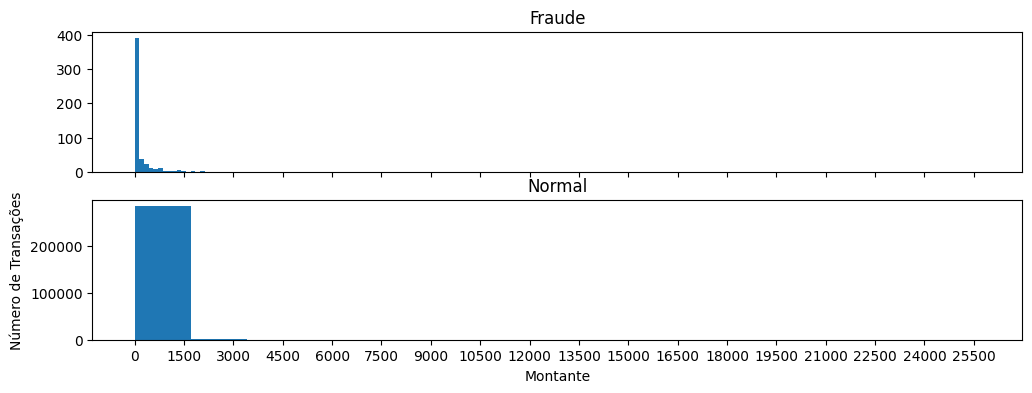

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
bins = 15

ax1.hist(df.Amount[df.Class == 1], bins =bins)
ax1.set_title('Fraude')

ax2.hist(df.Amount[df.Class == 0], bins = bins)
ax2.set_title('Normal')

x_ticks = np.arange(0, 26000, 1500)
plt.xticks(x_ticks)



plt.xlabel('Montante')
plt.ylabel('Número de Transações')
plt.show()

 Agora, vejamos os recursos gerados por PCA, como cada recurso se correlaciona com a classe.

PCA(é um procedimento matemático que utiliza uma transformação ortogonal (ortogonalização de vetores) para converter um conjunto de observações de variáveis possivelmente correlacionadas num conjunto de valores de variáveis linearmente não correlacionadas chamadas de componentes principais).

In [9]:
PCA_features = df.iloc[:,1:29].columns

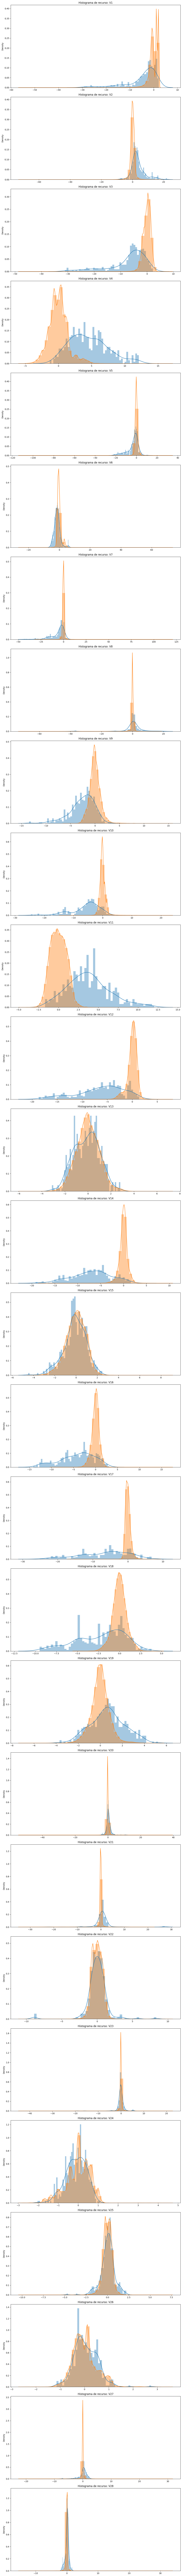

In [10]:

plt.figure(figsize=(12, 28*6))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate (df[PCA_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins = 50)
    sns.distplot(df[cn][df.Class == 0], bins = 50)
    ax.set_xlabel('')
    ax.set_title('Histograma de recurso: ' + str(cn))
    plt.tight_layout()
    
plt.show();

Parece que para as v8, v13, v15, v20, v23, v24, v25, v26, v27, v28, elas têm distribuição semelhante entre os dois tipos de transações. Para a seleção de recursos, podemos descartar esses recursos.

In [11]:
df = df.drop(['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8'], axis =1)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,-0.018307,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.225775,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.247998,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.108300,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,-0.009431,69.99,0


#### Escala de recursos

In [12]:
df['Normalized_Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V9,V10,...,V12,V14,V16,V17,V18,V19,V21,Amount,Class,Normalized_Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,...,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,-0.018307,149.62,0,0.244964
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,...,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.225775,2.69,0,-0.342475
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,...,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.247998,378.66,0,1.160686
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,...,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.108300,123.50,0,0.140534
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,...,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,-0.009431,69.99,0,-0.073403


In [13]:
df = df.drop(['Time', 'Amount'],axis = 1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,Class,Normalized_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,-0.018307,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.225775,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.247998,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.108300,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,-0.009431,0,-0.073403


#### Claramente, os dados estão totalmente desequilibrados! Abordagens:

reamostrar dados (subamostragem / superamostragem) e, em seguida, aplicar diferentes classificadores
logística de Regressão
SVM

## Reamostrando dados

Subamostragem: com base na proporção 50/50, escolha aleatoriamente amostras da classe normal


In [14]:
#Índices de classe Normal
indices_de_normal = df[df.Class == 0].index


#Escolha aleatoriamente a mesma quantidade de amostra que a fraude e retorne seus índices
aleatorios_indices_de_normal = np.array(np.random.choice(indices_de_normal, numeros_fraud , replace = False))

#índices de Classe Fraude
indices_de_fraude = np.array(df[df.Class == 1].index)

#indices de undersampled dataset
indice_de_undersampled = np.concatenate([aleatorios_indices_de_normal, indices_de_fraude])

#conjunto de dados com pouca amostra
data_de_undersampled  = df.iloc[indice_de_undersampled, :]

print(len(data_de_undersampled))


984


In [15]:
data_de_undersampled.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,Class,Normalized_Amount
80152,-0.670573,-0.631590,2.024853,-2.149100,-1.192555,0.339476,0.972565,2.451045,-1.654269,-0.907070,-0.062272,-1.030676,-1.217570,0.283289,-0.462718,0.098953,-0.024159,0,0.446388
194275,2.109631,-0.102756,-1.810893,0.095345,0.536760,-0.525560,0.174597,0.698831,0.015050,-1.455921,-0.219198,0.516511,0.051515,-0.774786,0.271341,0.061109,0.193554,0,-0.290739
185268,-0.809000,1.559748,-1.427954,-0.714430,0.450339,-0.396339,0.121917,-0.345525,-0.792672,0.259073,0.490492,-0.184854,0.908724,0.311445,0.544161,0.189489,-0.272617,0,-0.293818
116971,-0.393721,2.447663,-2.735273,1.483692,0.479673,-1.227152,0.026555,-0.552639,-0.891800,2.370655,0.416467,-2.791159,0.946708,3.177159,1.616263,-0.549969,-0.043584,0,-0.349671
122530,-0.788687,0.805496,0.293852,-1.844199,-0.371697,-1.274281,0.741598,0.448019,-1.465991,1.037444,1.385818,0.692597,-0.692418,-0.176871,0.280566,0.348246,0.214964,0,-0.166639


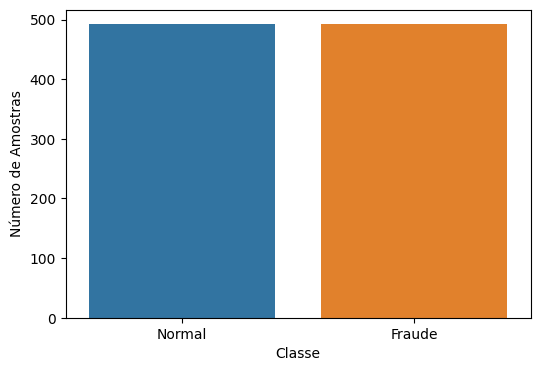

In [16]:
# Contar o número de amostras em cada classe
class_counts = data_de_undersampled['Class'].value_counts()

# Criar um gráfico de barras
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)

# Definir rótulos para os eixos
plt.xlabel('Classe')
plt.ylabel('Número de Amostras')

# Definir rótulos para as barras (opcional)
plt.xticks([0, 1], ['Normal', 'Fraude'])

# Exibir o gráfico
plt.show()

### 4. Prepare o conjunto de dados de treinamento e teste

In [17]:
#conjunto de dados inteiro
X = df.loc[:,df.columns!='Class']
y = df.loc[:,df.columns=='Class']

#treinar e testar o conjunto de dados dividido em todo o conjunto de dados, com proporção 70/30
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Numero de transacoes treinar conjunto de dados: ", len(X_train))
print("Conjunto de dados de teste de transacoes numericas: ", len(X_test))
print("Numero total de transacoes: ", len(X_train)+len(X_test))

Numero de transacoes treinar conjunto de dados:  199364
Conjunto de dados de teste de transacoes numericas:  85443
Numero total de transacoes:  284807


In [18]:
#conjunto de dados com pouca amostra
X_undersampled = data_de_undersampled.loc[:,data_de_undersampled.columns !='Class']
y_undersampled = data_de_undersampled.loc[:,data_de_undersampled.columns =='Class']

#conjunto de dados de trem e teste dividido a partir de um conjunto de dados com pouca amostra, com razão 70/30
X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled = train_test_split(X_undersampled,y_undersampled,test_size = 0.3, random_state = 0)

print("Numero de transacoes treinar conjunto de dados: ", len(X_train_undersampled))
print("Conjunto de dados de teste de transacoes numericas: ", len(X_test_undersampled))
print("Numero total de transacoes: ", len(X_train_undersampled)+len(X_test_undersampled))

Numero de transacoes treinar conjunto de dados:  688
Conjunto de dados de teste de transacoes numericas:  296
Numero total de transacoes:  984


### 5. Aplique diferentes classificadores

Definir uma função para treinar dados com diferentes classificadores com validação cruzada K-Fold para obter o melhor parâmetro C.

(O método de validação cruzada denominado k-fold consiste em dividir o conjunto total de dados em k subconjuntos mutuamente exclusivos do mesmo tamanho e, a partir daí, um subconjunto é utilizado para teste e os k-1 restantes são utilizados para estimação dos parâmetros, fazendo-se o cálculo da acurácia do modelo. Este processo é realizado k vezes alternando de forma circular o subconjunto de teste).


In [19]:
def train(model,X,y):
    
    # Recordar para o modelo
    clf = model
    
    # Diferentes parâmetros C para regularização
    C_param = [0.01,0.1,1,10,100]

    # Validação cruzada do K-Fold
    kf = KFold(n_splits=5)
    
    # Inicializacao
    scores     =[]
    best_score = 0
    best_C     = 0
    
    for C in C_param:
        
        clf.C = C

        score = []
        for train_index, test_index in kf.split(X): 

            # Use os dados de treinamento divididos para ajustar-se ao modelo.
            clf.fit(X.iloc[train_index,:].values,y.iloc[train_index,:].values.ravel())

            # Prever valores usando os dados de teste divididos
            y_pred = clf.predict(X.iloc[test_index,:].values)
            
            # Calcular a pontuação de rechamada e anexá-la a uma lista de pontuações de rechamada representando o parâmetro c_ atual
            rec = recall_score(y.iloc[test_index,:].values.ravel(),y_pred)
            
            # Anexar pontuação de recordar de cada iteração à pontuação
            score.append(rec)

        # Calcule a pontuação média real para todas as iterações e compare-a com a melhor pontuação.
        mean_score = np.mean(score)
        if mean_score > best_score:
            best_score = mean_score
            best_C     = C
        
        # Anexar a pontuação média de cada C às pontuações
        scores.append(np.mean(score))
        
    # Crie um quadro de dados para mostrar a pontuação média para cada parâmetro C    
    lr_results = pd.DataFrame({'Pontuacao':scores, 'C':C_param}) 
    print(lr_results)
    
    print("A melhor pontuacao de recordacao é: ", best_score)
    print("O melhor parametro C é: ", best_C)
    
    return best_score, best_C

Definir uma função para usar o melhor parâmetro C para treinar em diferentes conjuntos de dados de treinamento e prever em diferentes conjuntos de dados de teste; Plote confusion_matrix (existe uma função oficial para plotar matriz de confusão no sklearn: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) e imprima o relatório de classificação.

In [20]:
def predict(model, X_train, y_train, X_test, y_test):
    # Recordar para o modelo
    clf = model
    #clf = Regressão logística (C = C, penalidade = 'l1')
    # Use todo o conjunto de dados de trem com pouca amostra para ajustar-se ao modelo.
    clf.fit(X_train.values,y_train.values.ravel())
    # Previsão no conjunto de dados de teste com pouca amostra

    y_pred = clf.predict(X_test.values)

    # Matriz de confusão
    CM = confusion_matrix(y_test.values, y_pred)
    # Obter verdadeiros positivos (tp), falsos positivos (fp), falsos negativos (fn)
    tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

    # Prediction report
    sns.heatmap(CM,cmap="coolwarm_r",annot=True,linewidths=0.5)
    plt.title("Matriz_de_confusao")
    plt.xlabel("Classe_prevista")
    plt.ylabel("Classe Real")
    plt.show()
    print("\n----------Relatorio de classificacao------------------------------------")
    print(classification_report(y_test.values, y_pred))

### logística de Regressão
Primeiro, treine dados com pouca amostragem com o modelo de regressão logística + validação cruzada do K-Fold para obter o melhor parâmetro C

(O modelo de regressão logística é semelhante ao modelo de regressão linear. No entanto, no modelo logístico a variável resposta Y_i é binária. Uma variável binária assume dois valores, como por exemplo, Y_i=0 e Y_i=1, denominados "fracasso" e "sucesso", respectivamente).

In [21]:
clf = LogisticRegression(penalty = 'l2', solver ='lbfgs')
best_score, best_C = train(clf, X_train_undersampled,y_train_undersampled)

   Pontuacao       C
0   0.883357    0.01
1   0.903025    0.10
2   0.906460    1.00
3   0.909276   10.00
4   0.909276  100.00
A melhor pontuacao de recordacao é:  0.9092764354165673
O melhor parametro C é:  10


Segundo, treine em todo o conjunto de dados de trem com pouca amostra e preveja no conjunto de dados de teste com pouca amostra

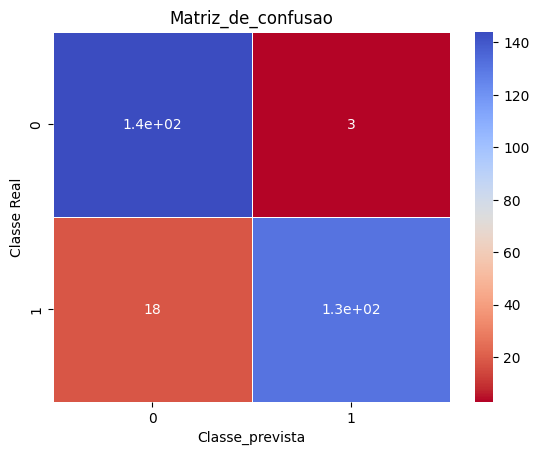


----------Relatorio de classificacao------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       147
           1       0.98      0.88      0.93       149

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296



In [22]:
clf = LogisticRegression(C=best_C, penalty = 'l2', solver ='lbfgs')
predict(clf, X_train_undersampled,y_train_undersampled,X_test_undersampled,y_test_undersampled)

A partir da matriz de confusão, podemos ver que apenas 19 das 149 amostras de fraude não foram previstas corretamente. E o modelo alcançou 92% de precisão de recordar. Isso é muito bom, vamos tentar o modelo para prever todo o conjunto de dados de teste em vez do conjunto de dados de teste com pouca amostra.

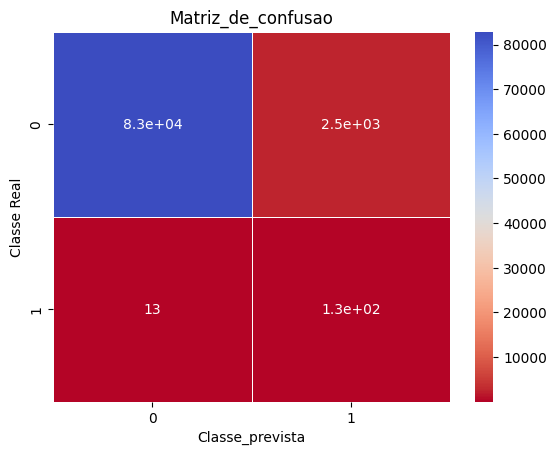


----------Relatorio de classificacao------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85296
           1       0.05      0.91      0.10       147

    accuracy                           0.97     85443
   macro avg       0.53      0.94      0.54     85443
weighted avg       1.00      0.97      0.98     85443



In [23]:
predict(clf,X_train_undersampled,y_train_undersampled,X_test,y_test)

A precisão da rechamada é quase a mesma (11 em 147) que a prevista no conjunto de dados de teste com pouca amostra. Portanto, parece que o modelo funciona bem com a subamostragem. Então, que tal aplicar o mesmo modelo em todos os conjuntos de dados sem reamostrar? Treinaremos todo o conjunto de dados com o mesmo modelo de regressão logística com validação cruzada e regularização K-Fold para obter o melhor parâmetro C, depois usaremos esse parâmetro para treinar e prever todo o conjunto de dados de trem e teste.

In [24]:
clf = LogisticRegression(penalty = 'l2',solver ='lbfgs')
best_score_whole, best_C_whole = train(clf,X_train,y_train)

   Pontuacao       C
0   0.584432    0.01
1   0.604700    0.10
2   0.608022    1.00
3   0.608022   10.00
4   0.608022  100.00
A melhor pontuacao de recordacao é:  0.6080222307849583
O melhor parametro C é:  1


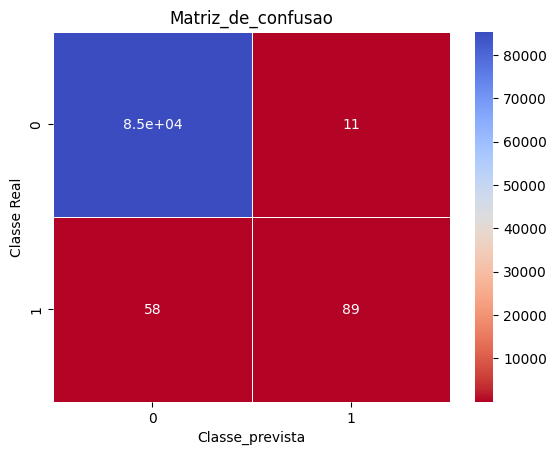


----------Relatorio de classificacao------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.89      0.61      0.72       147

    accuracy                           1.00     85443
   macro avg       0.94      0.80      0.86     85443
weighted avg       1.00      1.00      1.00     85443



In [25]:
clf = LogisticRegression(C=best_C_whole,penalty = 'l2',solver='lbfgs')
predict(clf,X_train,y_train,X_test,y_test)

Nesse caso, podemos ver que 58 das 147 fraudes não foram previstas corretamente. Portanto, é óbvio que, ao subamostrar os dados, aprimoramos o recordar de 61% para 93%. A subamostragem com regressão logística funciona muito bem para esse problema. Então, que tal outros classificadores? Como melhoramos ainda mais a precisão da previsão?


## SVM

SVM (Uma máquina de vetores de suporte é um conceito na ciência da computação para um conjunto de métodos do aprendizado supervisionado que analisam os dados e reconhecem padrões, usado para classificação e análise de regressão. O SVM padrão toma como entrada um conjunto de dados e prediz, para cada entrada dada, qual de duas possíveis classes a entrada faz parte, o que faz do SVM um classificador linear binário não probabilístico.

Vamos tentar o mesmo processo que a regressão logística. Primeiro ajustar o modelo no conjunto de dados com pouca amostra, prever o conjunto de dados de teste com pouca amostra e o conjunto de dados de teste inteiro, depois ajustar o modelo no conjunto de dados inteiro e prever o conjunto de dados de teste inteiro.

In [27]:
clf = SVC(gamma ='auto')
best_score, best_C = train(clf, X_train_undersampled, y_train_undersampled)

   Pontuacao       C
0   0.616901    0.01
1   0.923506    0.10
2   0.935268    1.00
3   0.948219   10.00
4   0.948219  100.00
A melhor pontuacao de recordacao é:  0.9482188990265297
O melhor parametro C é:  10


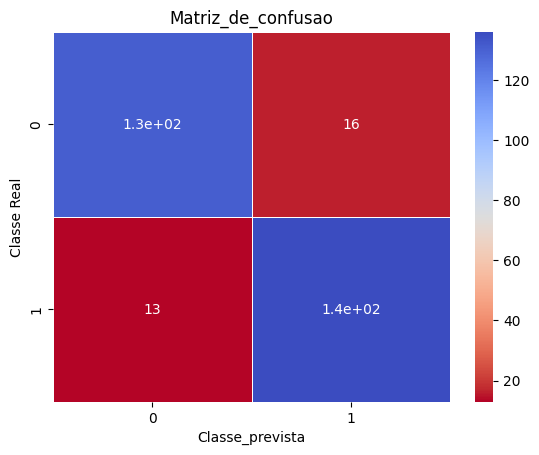


----------Relatorio de classificacao------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       147
           1       0.89      0.91      0.90       149

    accuracy                           0.90       296
   macro avg       0.90      0.90      0.90       296
weighted avg       0.90      0.90      0.90       296



In [29]:
clf = SVC(C=best_C, gamma='auto')
predict(clf, X_train_undersampled, y_train_undersampled, X_test_undersampled, y_test_undersampled)

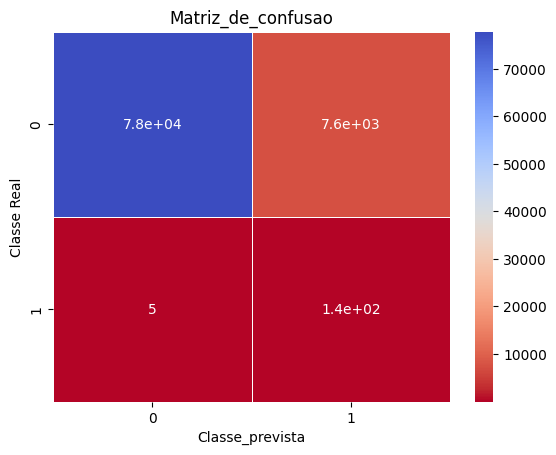


----------Relatorio de classificacao------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     85296
           1       0.02      0.97      0.04       147

    accuracy                           0.91     85443
   macro avg       0.51      0.94      0.49     85443
weighted avg       1.00      0.91      0.95     85443



In [30]:
predict(clf, X_train_undersampled, y_train_undersampled,X_test, y_test)

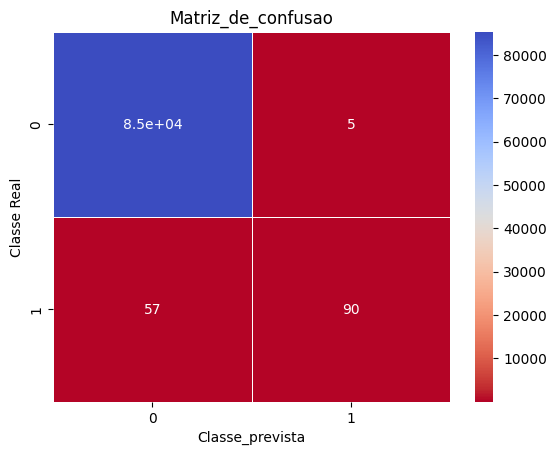


----------Relatorio de classificacao------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.95      0.61      0.74       147

    accuracy                           1.00     85443
   macro avg       0.97      0.81      0.87     85443
weighted avg       1.00      1.00      1.00     85443



In [31]:
predict(clf,X_train,y_train,X_test,y_test)